In [1]:
import pandas as pd
import optuna
import optunahub
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from optuna.samplers import TPESampler

## Currrently this file implements some basic feature engineering and optuna hyperparameter tuning with cv and wide range of hyperparams 

# Notes
- As first feat eng round increased the score , and the feat importance shows those in the top lets try if reducing the amount of vars affect it now
- with all new features and olds , these params got the new best score on kaggle : 0.7522

Best MAE 1.1546582705848174
Best params: {'n_estimators': 935, 'learning_rate': 0.01239831698396404, 'subsample': 0.8079401205533133, 'subsample_freq': 5, 'feature_fraction': 0.9, 'min_child_samples': 29, 'num_leaves': 248, 'max_depth': 8, 'min_gain_to_split': 0, 'lambda_l1': 4.219385786306642, 'lambda_l2': 3.3796737682500066, 'bagging_fraction': 0.5082774789319265, 'max_bin': 111, 'bagging_freq': 4, 'min_data_in_leaf': 44, 'cat_smooth': 29}
MAE: 1.1489859942028455
MSE: 2.4518278277124637
R2: 0.7475972710101345


- ANOTHER SET with more features engineered hyper params: 

Best MAE 1.150738382000109
Best params: {'n_estimators': 752, 'learning_rate': 0.02330489454002191, 'subsample': 0.3175973979353939, 'subsample_freq': 2, 'feature_fraction': 0.4, 'min_child_samples': 138, 'num_leaves': 46, 'max_depth': 9, 'min_gain_to_split': 0, 'lambda_l1': 0.5659643786319329, 'lambda_l2': 3.3944003730063748, 'bagging_fraction': 0.820300628486368, 'max_bin': 415, 'bagging_freq': 5, 'min_data_in_leaf': 73, 'cat_smooth': 84}
MAE: 1.1420662611247563
MSE: 2.4319663451925
R2: 0.7496419057651371

- Another one latest feat eng 4

Best MAE 1.1516328036958188
Best params: {'n_estimators': 537, 'learning_rate': 0.03632485718761969, 'subsample': 0.43586514808810384, 'subsample_freq': 3, 'feature_fraction': 0.8, 'min_child_samples': 94, 'num_leaves': 96, 'max_depth': 8, 'min_gain_to_split': 0, 'lambda_l1': 7.075707435476946, 'lambda_l2': 0.9640729989589089, 'bagging_fraction': 0.9748045608660398, 'max_bin': 134, 'bagging_freq': 8, 'min_data_in_leaf': 86, 'cat_smooth': 38}
MAE: 1.1388279704773183
MSE: 2.4283928105897004
R2: 0.7531777783677421

In [30]:
def feature_engineering(df):
    # Encode categorical features
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    
    # test somes simple features
    df['C_to_MW_ratio'] = df['NumOfC'] / df['MW']
    df['O_to_MW_ratio'] = df['NumOfO'] / df['MW']
    df['N_to_MW_ratio'] = df['NumOfN'] / df['MW']
    df['HBD_to_MW_ratio'] = df['NumHBondDonors'] / df['MW']
    # use log to scale the Conf_to_ConfUsed_ratio
    df['Conf_to_ConfUsed_ratio'] = np.log1p(df['NumOfConf'] / df['NumOfConfUsed'])
    
    # Interaction features
    df['C_O_interaction'] = df['NumOfC'] * df['NumOfO']
    df['C_N_interaction'] = df['NumOfC'] * df['NumOfN']
    
    df['log_MW'] = np.log1p(df['MW'])
    df['log_NumOfAtoms'] = np.log1p(df['NumOfAtoms'])
    
    df = pd.get_dummies(df, columns=['parentspecies'])
    
    return df, label_encoders

def feature_engineering2(df):
    # Test some simple features
    df['C_to_MW_ratio'] = df['NumOfC'] / df['MW']
    df['O_to_MW_ratio'] = df['NumOfO'] / df['MW']
    df['N_to_MW_ratio'] = df['NumOfN'] / df['MW']
    df['HBD_to_MW_ratio'] = df['NumHBondDonors'] / df['MW']
    df['Conf_to_ConfUsed_ratio'] = np.log1p(df['NumOfConf'] / df['NumOfConfUsed'])
    df['log_NumOfConf'] = np.log1p(df['NumOfConf'])
    df['sqrt_NumOfConfUsed'] = np.sqrt(df['NumOfConfUsed'])
    
    # Interaction features
    df['C_O_interaction'] = df['NumOfC'] * df['NumOfO']
    df['C_N_interaction'] = df['NumOfC'] * df['NumOfN']
    
    # testing random features
    df['Special2_log'] = np.log1p(df['NumOfConf'] * df['NumHBondDonors'])
    df['Special2'] = df['NumOfConf'] * df['NumHBondDonors']
    df['total_groups_mean'] = df[['hydroxyl (alkyl)', 'ketone', 'aldehyde', 'carboxylic acid', 'ester', 'ether (alicyclic)', 'nitrate', 'nitro', 'aromatic hydroxyl', 'carbonylperoxynitrate', 'peroxide', 'hydroperoxide', 'carbonylperoxyacid', 'nitroester']].mean(axis=1)
    df['total_groups'] = df['hydroxyl (alkyl)'] + df['ketone'] + df['aldehyde'] + df['carboxylic acid'] + df['ester'] + df['ether (alicyclic)'] + df['nitrate'] + df['nitro'] + df['aromatic hydroxyl'] + df['carbonylperoxynitrate'] + df['peroxide'] + df['hydroperoxide'] + df['carbonylperoxyacid'] + df['nitroester']
    df['Special420'] = df['total_groups'] * df['NumOfC']
    df['Special421'] = df['total_groups'] * df['NumOfO']
    df['Special422'] = df['total_groups'] * df['NumOfN']
    df['Special423'] = df['NumHBondDonors'] * df['total_groups']
    df['Special424'] = df['NumHBondDonors'] * df['NumOfAtoms']
    
    # Dummyt categorical features
    df = pd.get_dummies(df, columns=['parentspecies'])
    
    # Standardize features
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # dont scale the id column
    numeric_cols = numeric_cols.drop('ID')
    if 'log_pSat_Pa' in numeric_cols:
        numeric_cols = numeric_cols.drop('log_pSat_Pa')
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    return df
def feature_engineering3(df):
    # do same things but for linear regression model 
    # Test some simple features
    df['C_to_MW_ratio'] = df['NumOfC'] / df['MW']
    df['O_to_MW_ratio'] = df['NumOfO'] / df['MW']
    df['N_to_MW_ratio'] = df['NumOfN'] / df['MW']
    df['HBD_to_MW_ratio'] = df['NumHBondDonors'] / df['MW']
    df['Conf_to_ConfUsed_ratio'] = np.log1p(df['NumOfConf'] / df['NumOfConfUsed'])
    
    # Interaction features
    df['C_O_interaction'] = df['NumOfC'] * df['NumOfO']
    df['C_N_interaction'] = df['NumOfC'] * df['NumOfN']
    df['Special'] = df['NumOfC'] * df['NumOfO'] * df['NumOfN']
    df['Special2'] = df['NumOfConf'] * df['NumHBondDonors']
    
    # Log transformations
    df['log_MW'] = np.log1p(df['MW'])
    df['log_NumOfAtoms'] = np.log1p(df['NumOfAtoms'])
    
    # Dummyt categorical features
    df = pd.get_dummies(df, columns=['parentspecies'])
    
    return df

def feature_engineering4(df):
    # with feedback from feateng2 feature importance , lets try reduce some features
    df['Conf_to_ConfUsed_ratio'] = np.log1p(df['NumOfConf'] / df['NumOfConfUsed'])
    df['Special2_log'] = np.log1p(df['NumOfConf'] * df['NumHBondDonors'])
    df['log_MW'] = np.log1p(df['MW'])
    df['C_to_MW_ratio'] = df['NumOfC'] / df['MW']
    df['O_to_MW_ratio'] = df['NumOfO'] / df['MW']
    df['N_to_MW_ratio'] = df['NumOfN'] / df['MW']
    df['log_NumOfConf'] = np.log1p(df['NumOfConf'])
    df['sqrt_NumOfConfUsed'] = np.sqrt(df['NumOfConfUsed'])
    df['total_groups_mean'] = df[['hydroxyl (alkyl)', 'ketone', 'aldehyde', 'carboxylic acid', 'ester', 'ether (alicyclic)', 'nitrate', 'nitro', 'aromatic hydroxyl', 'carbonylperoxynitrate', 'peroxide', 'hydroperoxide', 'carbonylperoxyacid', 'nitroester']].mean(axis=1)
    df['Special420'] = df['total_groups_mean'] * df['NumOfC']
    df['Special421'] = df['total_groups_mean'] * df['NumOfO']
    df['Special422'] = df['total_groups_mean'] * df['NumOfN']
    df['Special423'] = df['NumHBondDonors'] * df['total_groups_mean']
    df['Special424'] = df['NumHBondDonors'] * df['NumOfAtoms']
    df['extraspecial'] = df['NumHBondDonors'] * df['log_MW']

    df = pd.get_dummies(df, columns=['parentspecies'])
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = numeric_cols.drop('ID')
    if 'log_pSat_Pa' in numeric_cols:
        numeric_cols = numeric_cols.drop('log_pSat_Pa')
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df
    

## With the featureengineering2 lgbm 

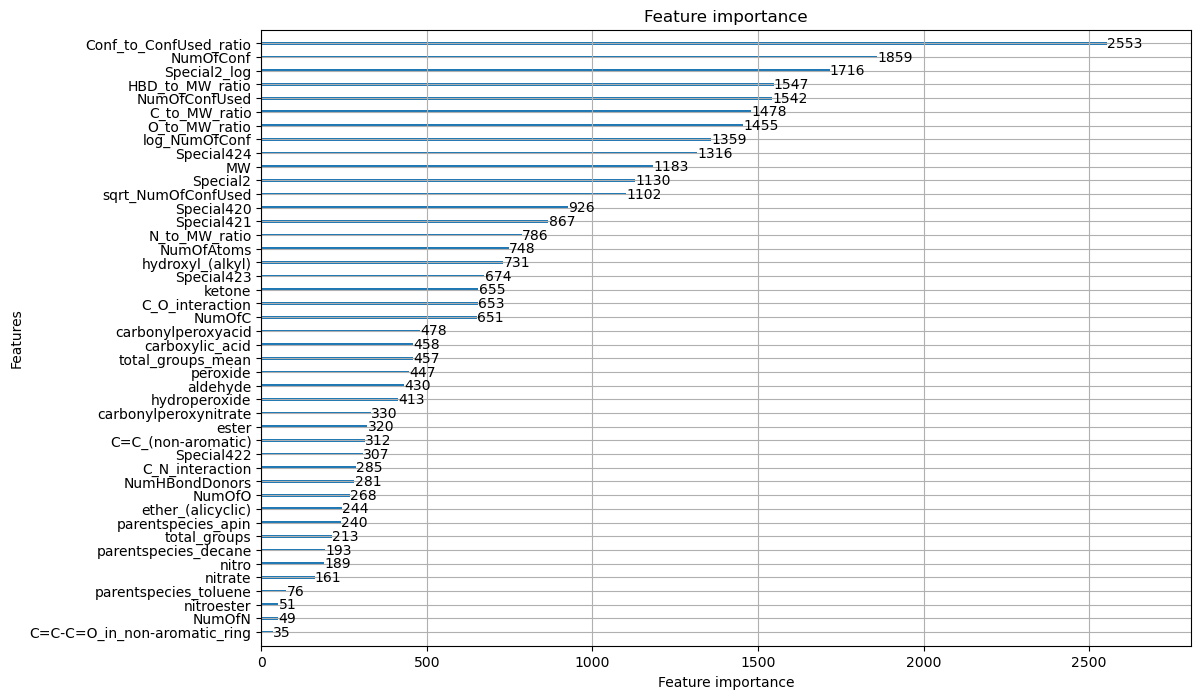

## WITH LATES FEATENG4

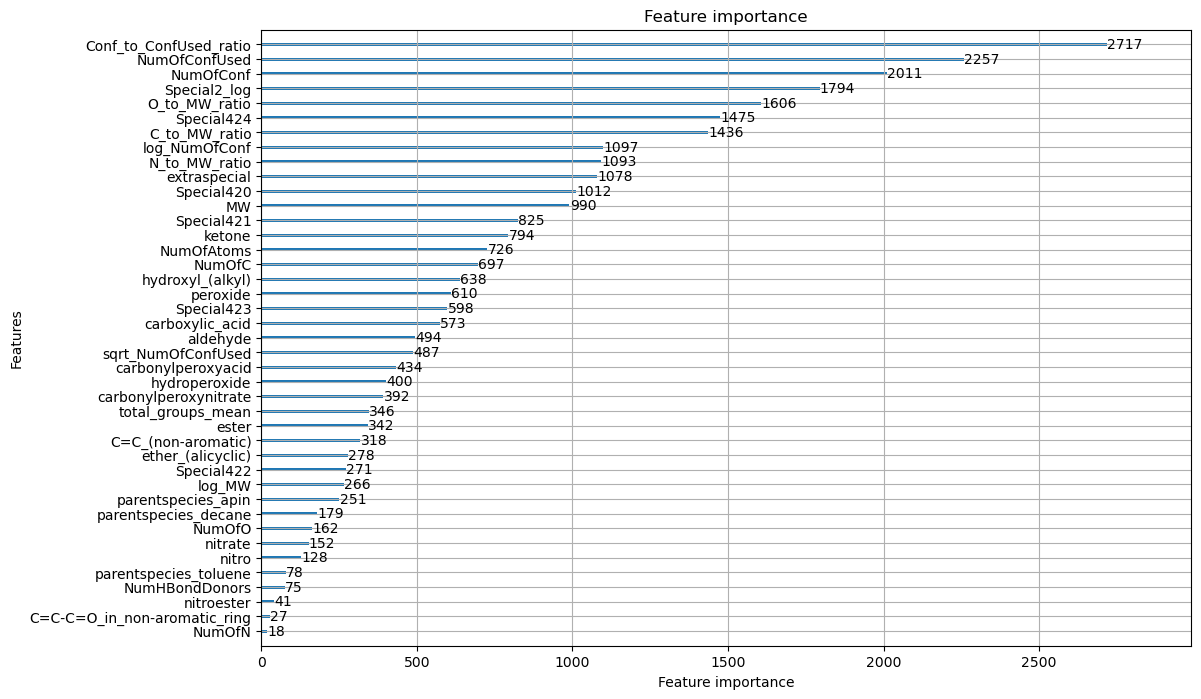

In [92]:
# get summary of the vars in train_x
#print(train_x.describe())
#print(train_x.select_dtypes(include=[np.number]).columns)
print(train.select_dtypes(include=[np.number]).columns)

Index(['ID', 'log_pSat_Pa', 'MW', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
       'NumHBondDonors', 'NumOfConf', 'NumOfConfUsed', 'C=C (non-aromatic)',
       'C=C-C=O in non-aromatic ring', 'hydroxyl (alkyl)', 'aldehyde',
       'ketone', 'carboxylic acid', 'ester', 'ether (alicyclic)', 'nitrate',
       'nitro', 'aromatic hydroxyl', 'carbonylperoxynitrate', 'peroxide',
       'hydroperoxide', 'carbonylperoxyacid', 'nitroester', 'C_to_MW_ratio',
       'O_to_MW_ratio', 'N_to_MW_ratio', 'HBD_to_MW_ratio',
       'Conf_to_ConfUsed_ratio', 'C_O_interaction', 'C_N_interaction',
       'Special', 'Special2', 'log_MW', 'log_NumOfAtoms'],
      dtype='object')


In [31]:
db_path = "sqlite:///../Data/optuna.db"
study_name = "iml_experiment_V1"

# Create a new study or load an existing one
study = optuna.create_study(study_name=study_name,
                            storage=db_path,
                            load_if_exists=True,
                            direction="minimize",
                            sampler=TPESampler(seed=17)
                            #sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler()
                            )

# Load the data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

train = feature_engineering4(train)
test = feature_engineering4(test)

# Ensure the same columns in train and test
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Split the data
X = train.drop(columns=["log_pSat_Pa", "ID"])
y = train["log_pSat_Pa"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=17)
test = test.drop(columns=["ID"])

[I 2024-11-23 22:15:19,980] Using an existing study with name 'iml_experiment_V1' instead of creating a new one.


## This tuning is quite an exhausting right now 
### its possible to fit and do this in 20 sec 
### this exhausting hyperparam search is done due the push that can be gained with it witch might be quite small
### fast fit can easily score over 0.74

In [32]:
def improved_objective_func(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.25, 0.95),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.9, step=0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 150),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        "max_depth": trial.suggest_int('max_depth', -1, 15),
        "min_gain_to_split": trial.suggest_int('min_gain_to_split', 0, 15),
        "lambda_l1": trial.suggest_float('lambda_l1', 0.0, 10),
        "lambda_l2": trial.suggest_float('lambda_l2', 0.0, 10),
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.4, 1),
        "max_bin": trial.suggest_int('max_bin', 100, 500),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 10),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 100),
        "cat_smooth": trial.suggest_int('cat_smooth', 1, 100),
        'random_state': 74
    }
    model = lgb.LGBMRegressor(**params, verbose=-1)
    kf = KFold(n_splits=5, shuffle=True, random_state=17)
    mae_scores = []
    
    for train_index, val_index in kf.split(train_x):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)])
        
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

# Create a study and optimize
study.optimize(improved_objective_func, n_trials=150)
print(f"Best trial: {study.best_trial.params}")

[I 2024-11-23 22:15:28,282] Trial 0 finished with value: 1.1617390898787783 and parameters: {'n_estimators': 365, 'learning_rate': 0.027041933351385973, 'subsample': 0.3840645508632464, 'subsample_freq': 1, 'feature_fraction': 0.8, 'min_child_samples': 102, 'num_leaves': 82, 'max_depth': 8, 'min_gain_to_split': 0, 'lambda_l1': 3.5781360448354893, 'lambda_l2': 9.456831868184075, 'bagging_fraction': 0.43602680818923123, 'max_bin': 446, 'bagging_freq': 9, 'min_data_in_leaf': 6, 'cat_smooth': 66}. Best is trial 0 with value: 1.1617390898787783.
[I 2024-11-23 22:15:34,095] Trial 1 finished with value: 1.1720645266414436 and parameters: {'n_estimators': 597, 'learning_rate': 0.040989285467635875, 'subsample': 0.5884700370170015, 'subsample_freq': 3, 'feature_fraction': 0.4, 'min_child_samples': 89, 'num_leaves': 52, 'max_depth': 12, 'min_gain_to_split': 6, 'lambda_l1': 1.4390392077532788, 'lambda_l2': 1.5090669442067706, 'bagging_fraction': 0.4331448101294943, 'max_bin': 387, 'bagging_freq':

Best trial: {'n_estimators': 537, 'learning_rate': 0.03632485718761969, 'subsample': 0.43586514808810384, 'subsample_freq': 3, 'feature_fraction': 0.8, 'min_child_samples': 94, 'num_leaves': 96, 'max_depth': 8, 'min_gain_to_split': 0, 'lambda_l1': 7.075707435476946, 'lambda_l2': 0.9640729989589089, 'bagging_fraction': 0.9748045608660398, 'max_bin': 134, 'bagging_freq': 8, 'min_data_in_leaf': 86, 'cat_smooth': 38}


In [33]:
print("Best MAE", study.best_value)
print("Best params:", study.best_trial.params)

# train the model with the best params
best_params = study.best_trial.params
model = lgb.LGBMRegressor(**best_params, verbose=-1)
model.fit(train_x, train_y)
preds = model.predict(test_x)
mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, preds)
print("MAE:", mae)
print("MSE:", mse)
print("R2:", r2)

Best MAE 1.1516328036958188
Best params: {'n_estimators': 537, 'learning_rate': 0.03632485718761969, 'subsample': 0.43586514808810384, 'subsample_freq': 3, 'feature_fraction': 0.8, 'min_child_samples': 94, 'num_leaves': 96, 'max_depth': 8, 'min_gain_to_split': 0, 'lambda_l1': 7.075707435476946, 'lambda_l2': 0.9640729989589089, 'bagging_fraction': 0.9748045608660398, 'max_bin': 134, 'bagging_freq': 8, 'min_data_in_leaf': 86, 'cat_smooth': 38}
MAE: 1.1388279704773183
MSE: 2.4283928105897004
R2: 0.7531777783677421


In [34]:
important_hyperparams = sorted(study.best_trial.params, key=study.best_trial.params.get, reverse=True)[:3]
optuna.visualization.plot_slice(study=optuna.load_study(study_name=study_name, storage=db_path), params=important_hyperparams)

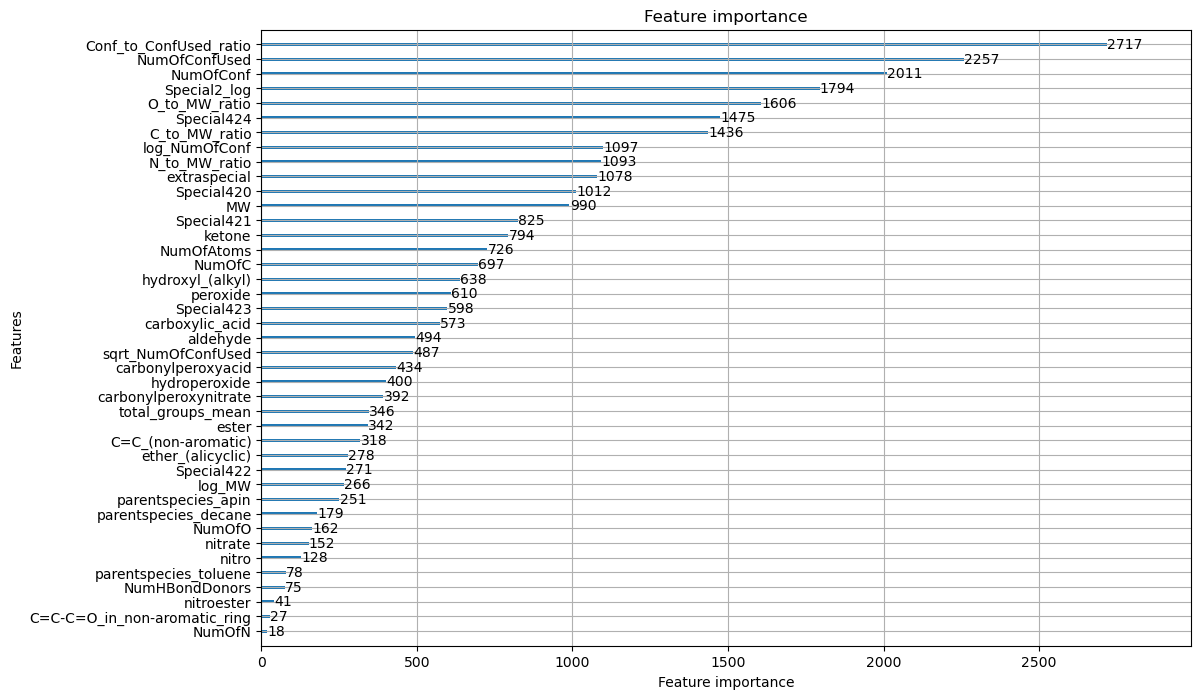

In [35]:
# Plot the feature importance
fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(model, ax=ax)
plt.show()

# plot hyperparameter importance
optuna.visualization.plot_param_importances(study).show()


In [38]:
# do the predictions to the test data and store the results in column : TARGET

if "TARGET" in test.columns:
    test = test.drop(columns=["TARGET"])
test["TARGET"] = model.predict(test.drop(columns=["ID", "parentspecies"]))

# save the ID and TArGET columns to a csv file called : optana_lgbm.csv
test[["ID", "TARGET"]].to_csv("optana_lgbm.csv", index=False)

KeyError: "['ID', 'parentspecies'] not found in axis"

In [36]:
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

train = feature_engineering4(train)
test = feature_engineering4(test)

# Ensure the same columns in train and test
train, test = train.align(test, join='left', axis=1, fill_value=0)

# view test data
print(test)

# Predict on test data and store predicts ( name the col TARGET ) and ID in new csv
test["TARGET"] = model.predict(test.drop(columns=["ID", "log_pSat_Pa"]))
test[["ID", "TARGET"]].to_csv(f'../Data/optuna_lgbm_cv_{study_name}.csv', index=False)


         ID  log_pSat_Pa        MW  NumOfAtoms    NumOfC    NumOfO    NumOfN  \
0        24            0  1.274419   -0.030783 -0.592423  1.621067  1.324808   
1        28            0  1.950745    0.739745 -0.592423  2.414424  1.324808   
2        29            0 -0.534542   -0.608678 -0.592423 -0.362326 -0.075327   
3        33            0  1.554620    2.088168  1.507376  0.827710  1.324808   
4        58            0  0.956301   -0.223414 -0.592423  1.224388  1.324808   
...     ...          ...       ...         ...       ...       ...       ...   
4995  31590            0 -0.871007    0.932377  1.507376 -1.552362 -1.475462   
4996  31591            0 -0.295878   -0.416046  0.107510 -0.362326 -0.075327   
4997  31605            0  0.698566    0.547113  0.107510  0.827710 -0.075327   
4998  31609            0 -0.833090   -0.993942 -0.592423 -0.362326 -1.475462   
4999  31610            0  0.379724   -0.416046 -0.592423  0.827710 -0.075327   

      NumHBondDonors  NumOfConf  NumOfC

In [ ]:
# try regular OLS with the new feature engineering2

from sklearn.linear_model import LinearRegression


train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

train = feature_engineering3(train)
test = feature_engineering3(test)

# Ensure the same columns in train and test
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Split the data
X = train.drop(columns=["log_pSat_Pa", "ID"])
y = train["log_pSat_Pa"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=74)

# fit the model
model = LinearRegression()
model.fit(train_x, train_y)
preds = model.predict(test_x)
mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, preds)
print("MAE:", mae)
print("MSE:", mse)
print("R2:", r2)

# predict on the test data and save it to a csv file with cols ID, TARGET
if "TARGET" in test.columns:
    test = test.drop(columns=["TARGET"])
test["TARGET"] = model.predict(test.drop(columns=["ID", "log_pSat_Pa"]))
test[["ID", "TARGET"]].to_csv(f"optuna_ols.csv", index=False)


MAE: 1.1970191996716701
MSE: 2.6007843153332533
R2: 0.7322629871133284


### 0.73? or similar also in kaggle so there is improvement significantly there too

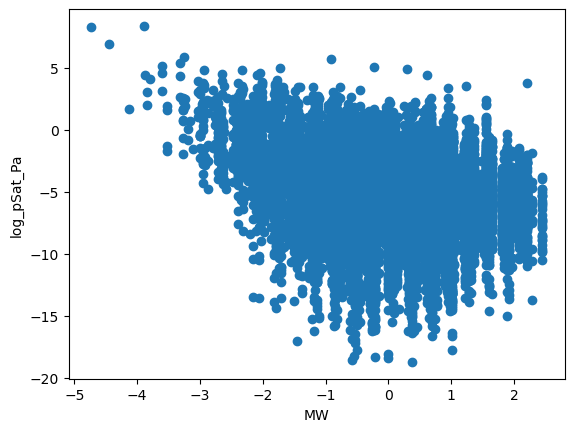

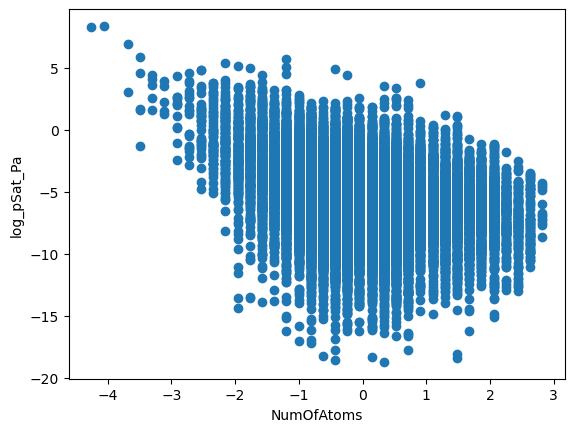

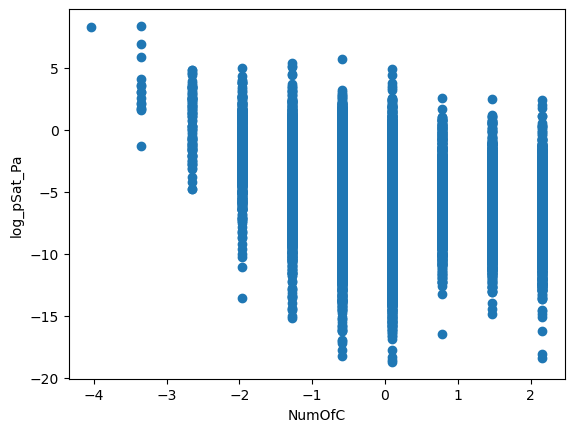

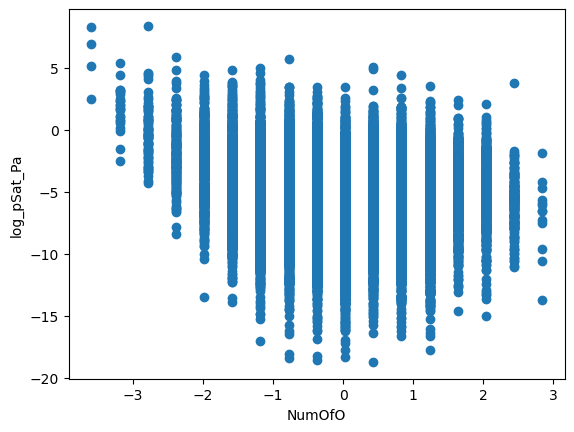

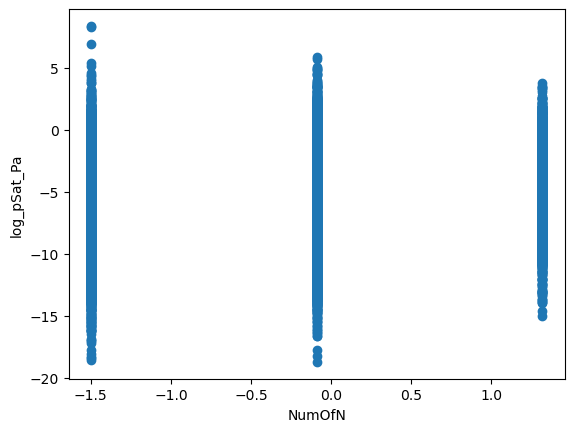

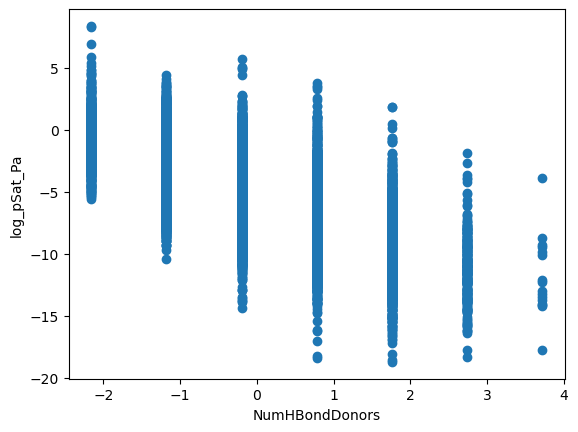

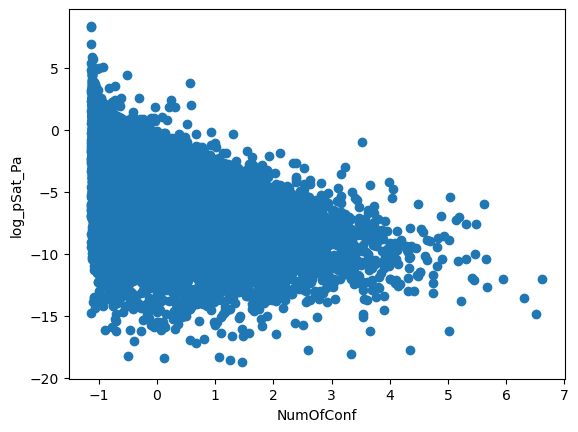

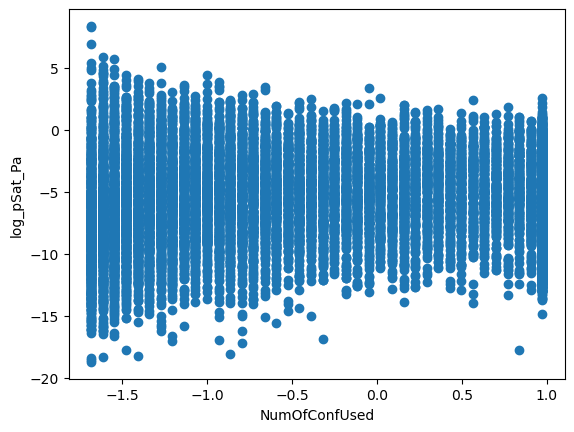

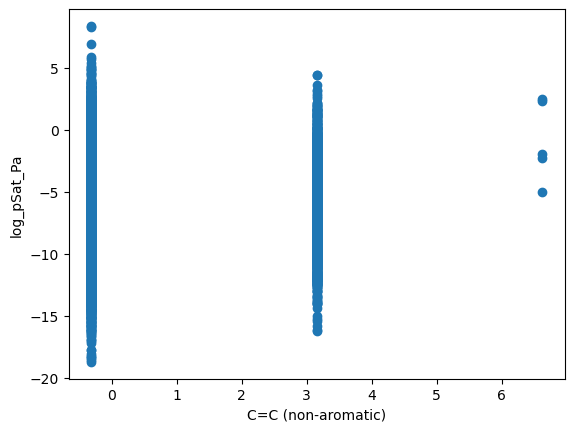

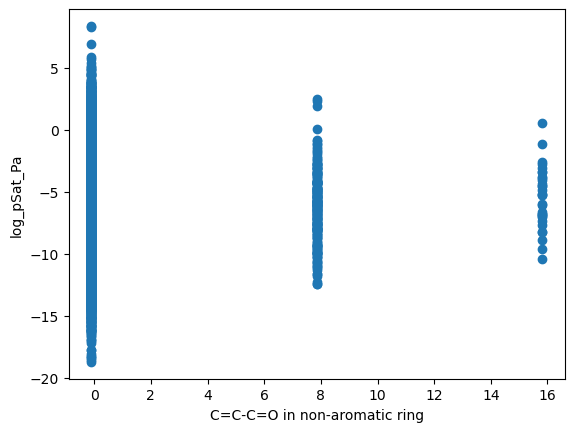

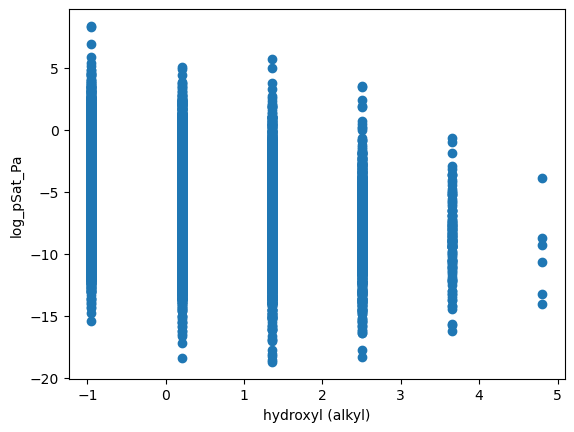

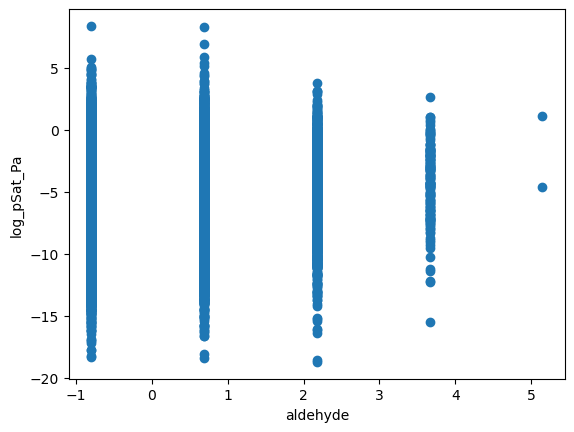

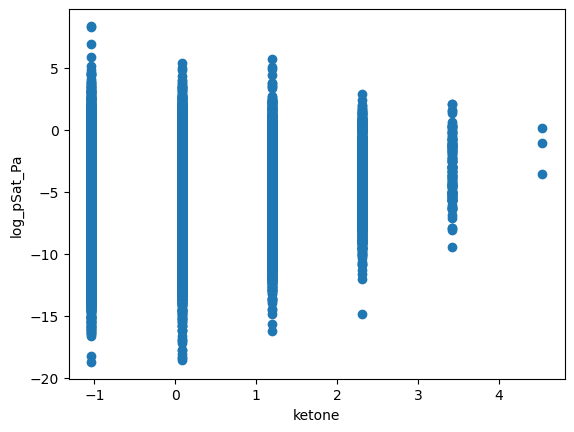

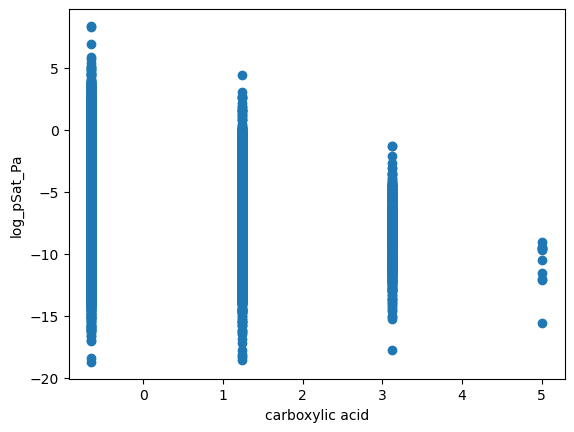

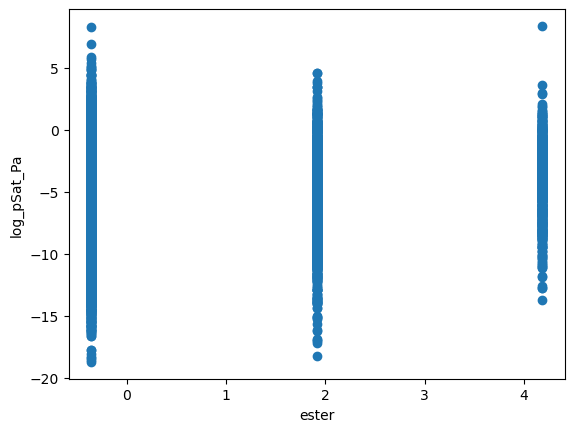

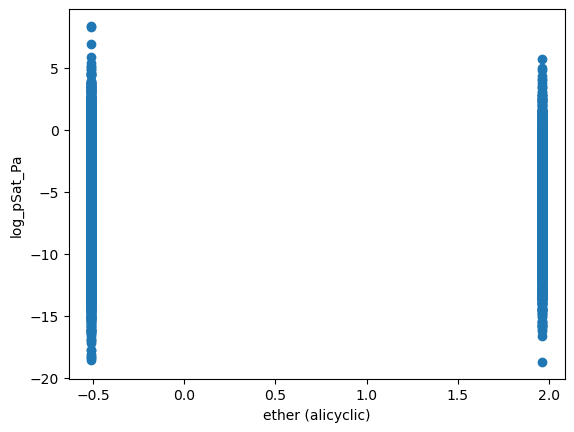

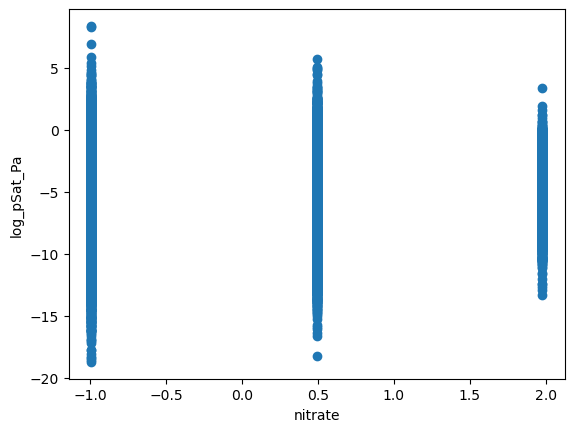

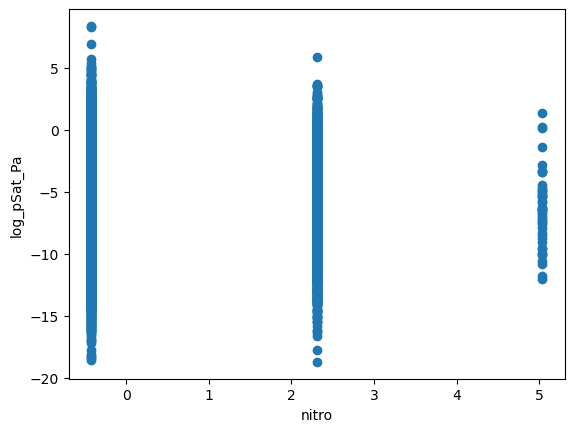

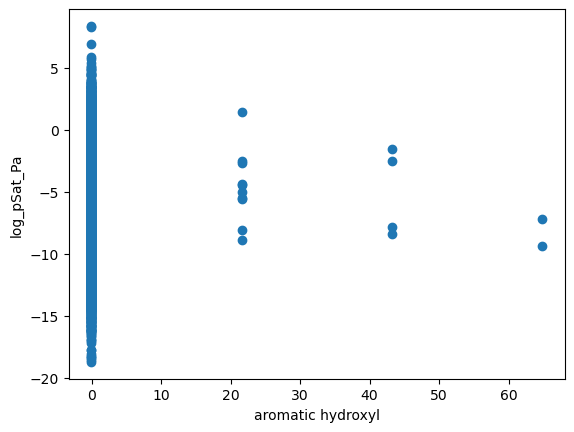

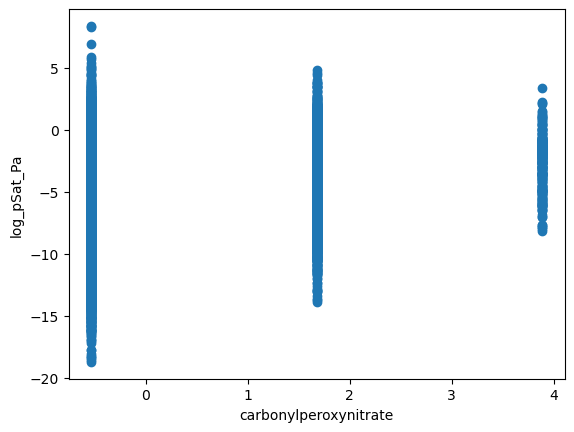

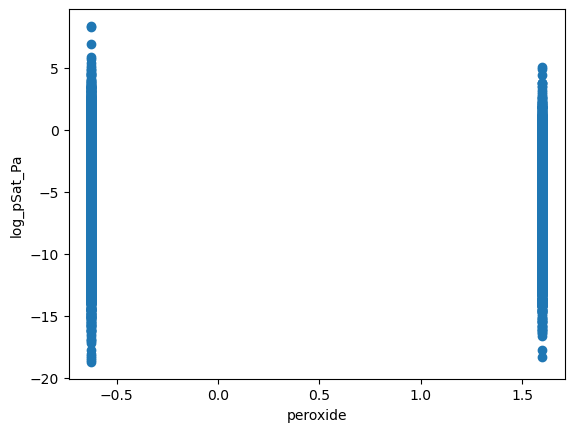

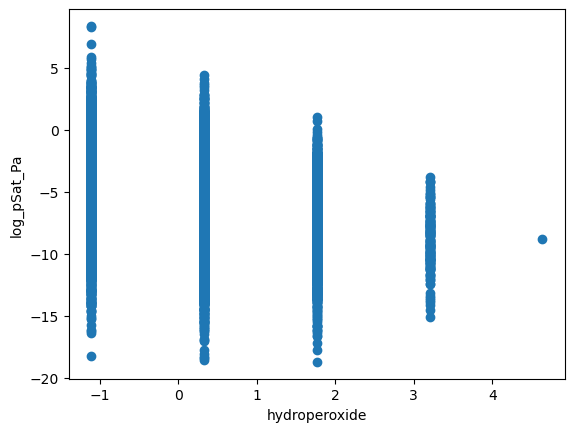

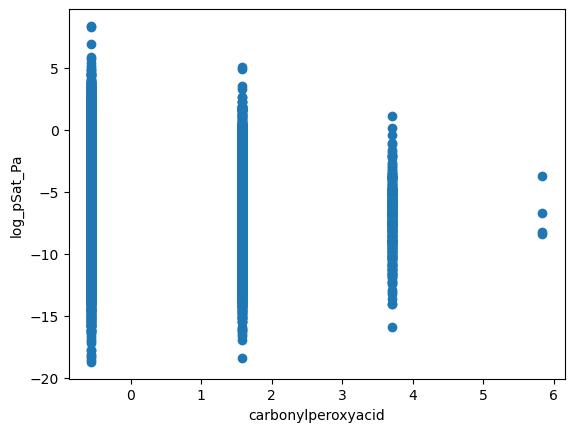

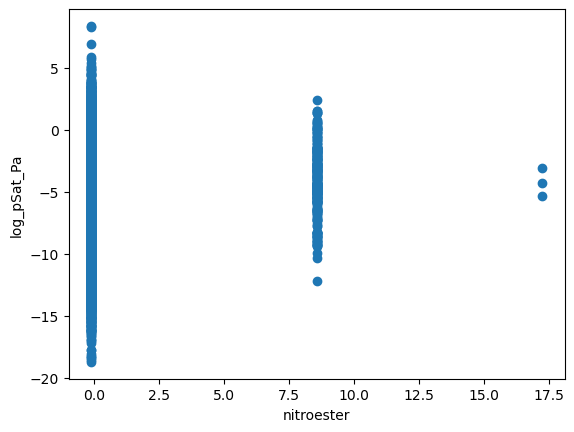

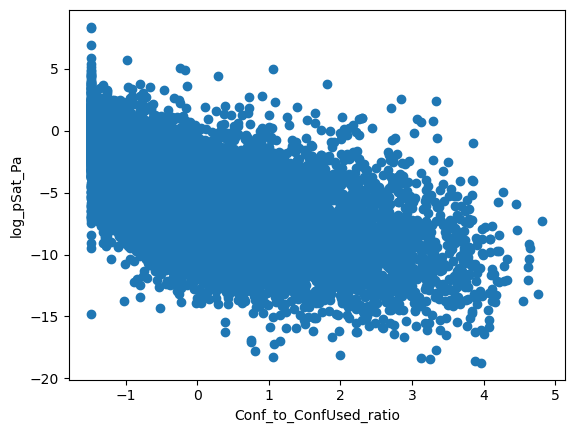

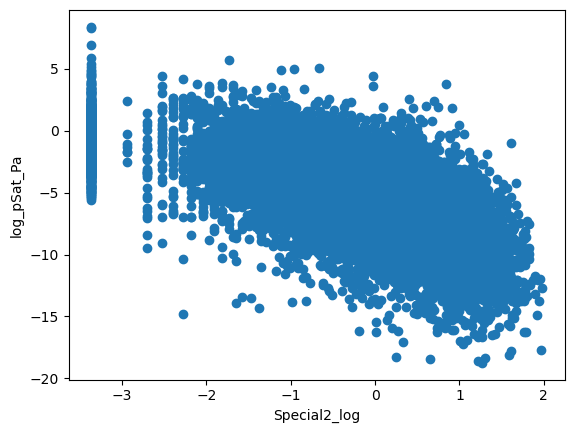

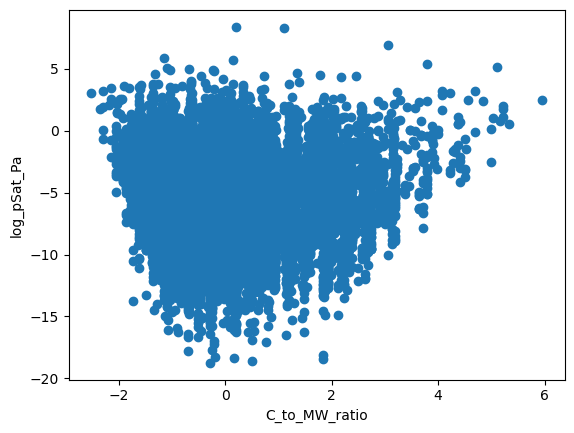

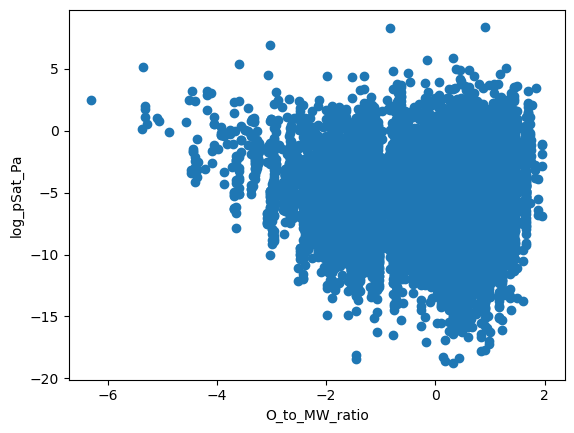

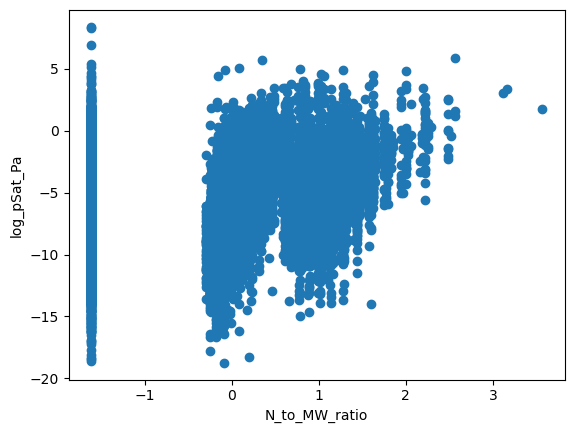

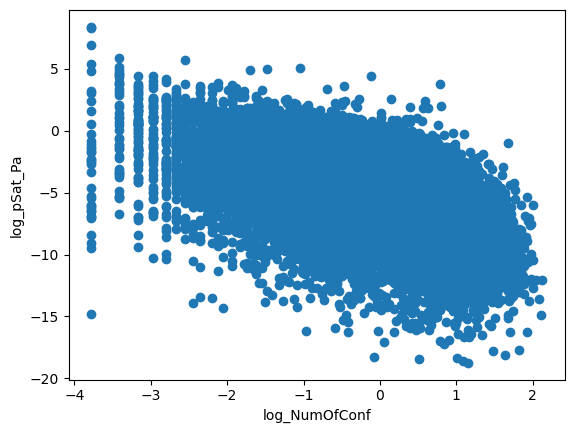

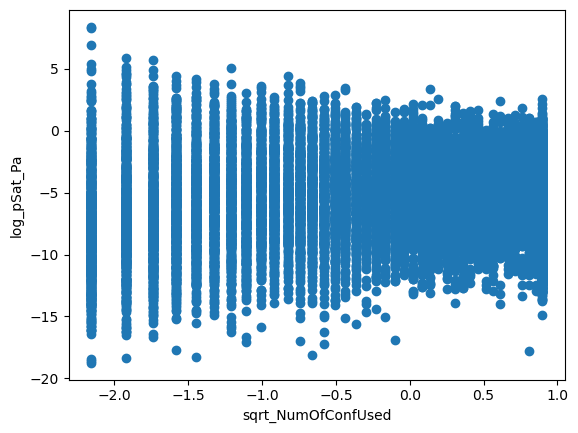

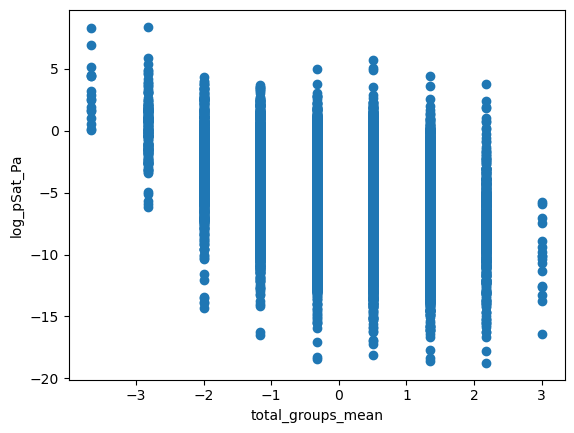

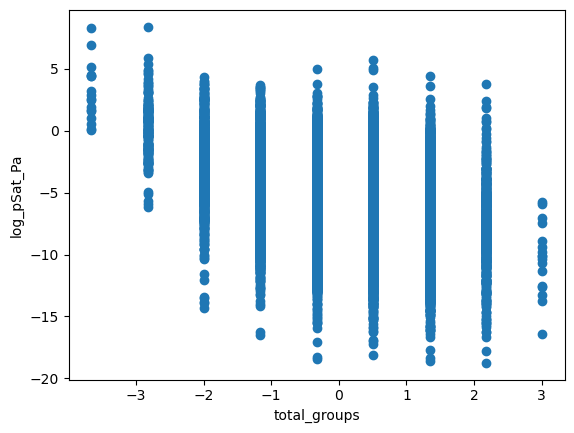

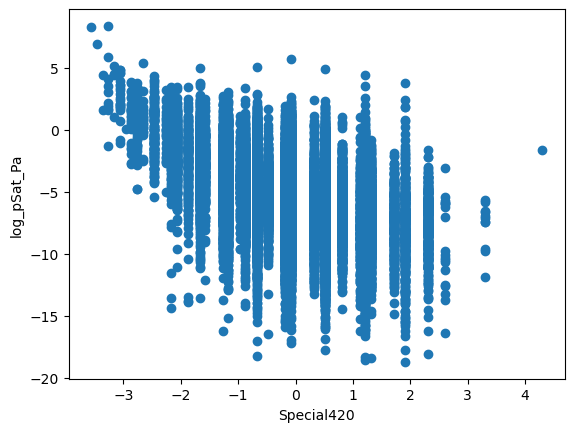

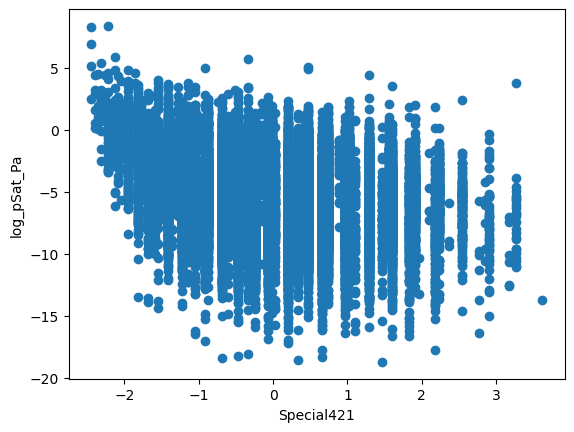

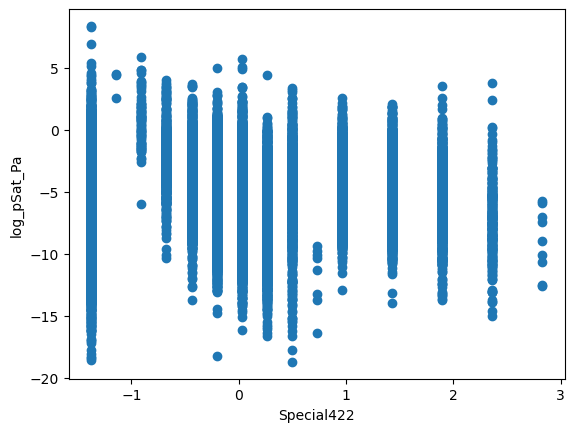

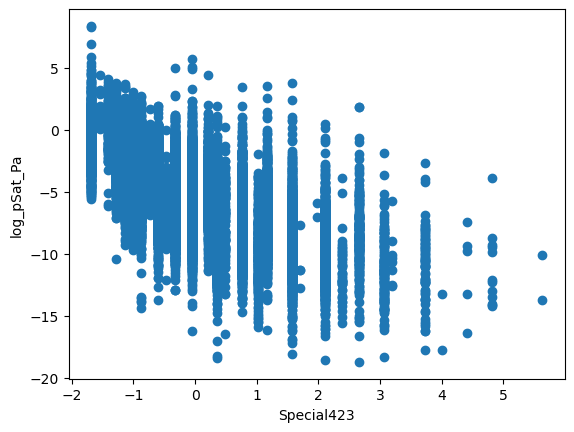

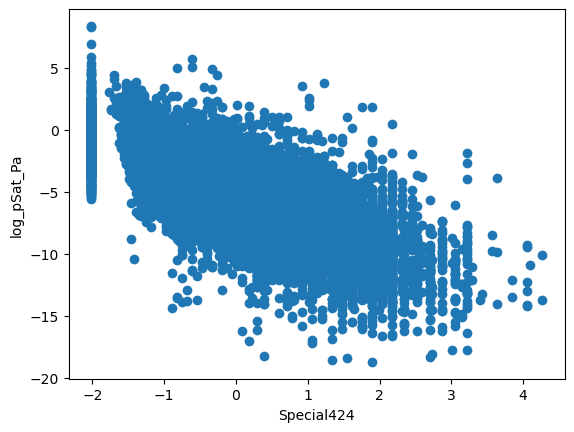

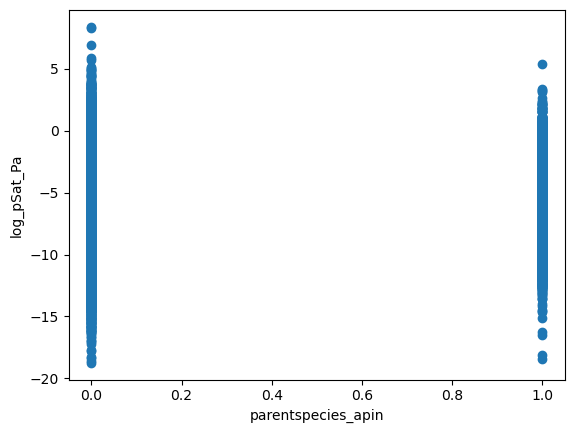

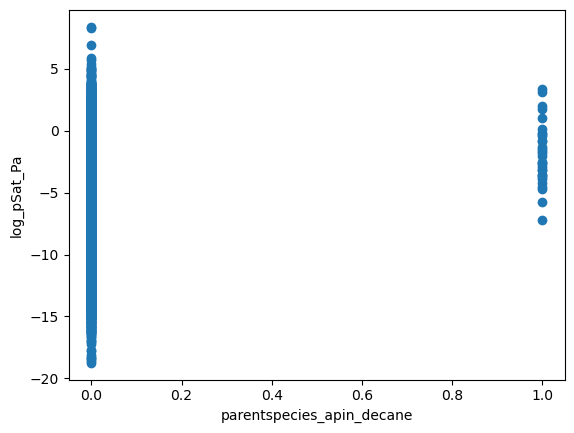

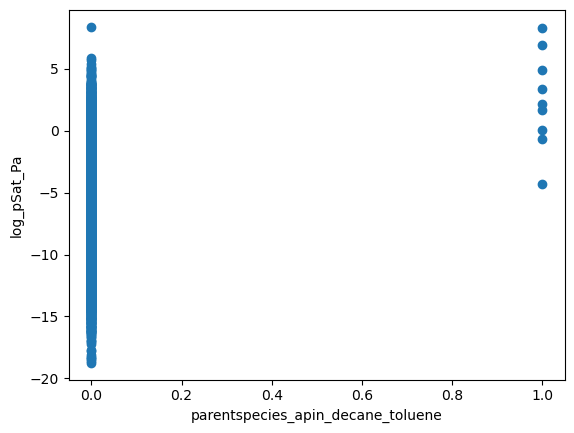

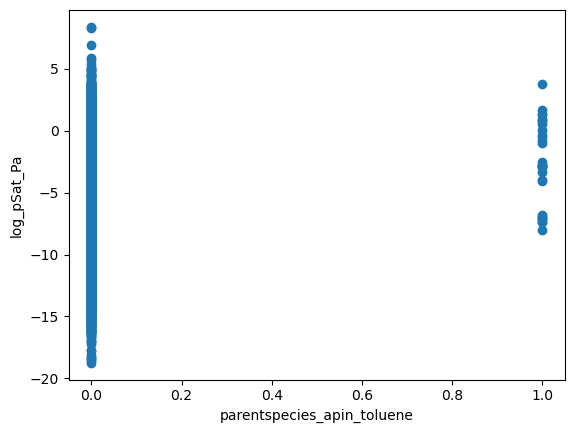

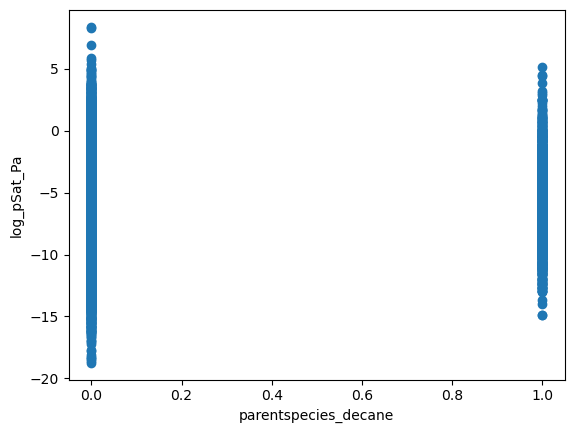

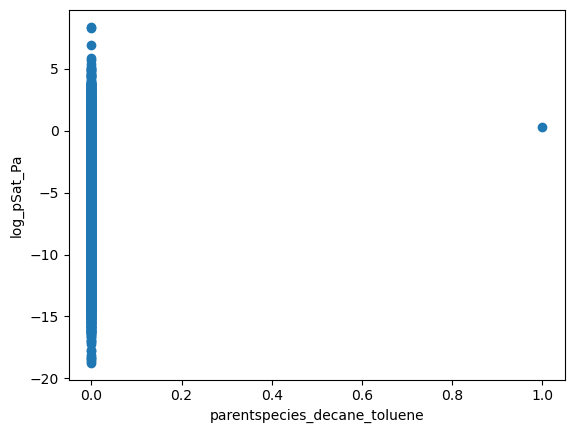

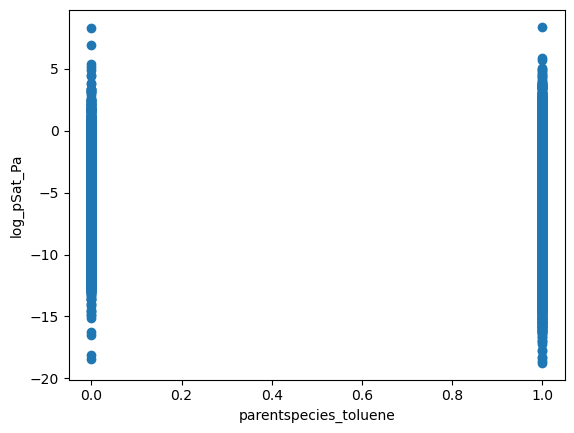

In [ ]:
# lets see if we spot the log_pSat_Pa and feature relatioshit by scatter plot one by one

# create loop that compares each variable at time to log_pSat_Pa
for col in train_x.columns:
    plt.scatter(train_x[col], train_y)
    plt.xlabel(col)
    plt.ylabel("log_pSat_Pa")
    plt.show()
    as = input("Press enter to continue")
